<a href="https://colab.research.google.com/github/alastra32/DS-Unit-2-Applied-Modeling/blob/master/module1/assignment_applied_modeling_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?

## Reading

### ROC AUC
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

### Imbalanced Classes
- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)

### Last lesson
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


# process for the actual submission

## Setup - MB

In [27]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# merge train_features.csv & train_labels.csv
trainandval = pd.merge(pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_features.csv'), 
                 pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/train_labels.csv'))

# read test_features.csv & sample_submission.csv
test = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/test_features.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-2-Kaggle-Challenge/master/data/tanzania/sample_submission.csv')

In [0]:
# import block
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import category_encoders as ce
from xgboost import XGBClassifier

In [30]:
# train validation split
train, val = train_test_split(trainandval, train_size=0.95, test_size=0.05, 
                              stratify=trainandval['status_group'], random_state=42)

train.shape, val.shape, test.shape

((56430, 41), (2970, 41), (14358, 40))

## Manual Mode - MB

In [0]:
# We need a function that returns the mode of a given series for the imputer function.
def manual_mode(feature):
  try: 
    return feature.mode()[0]
  except:
    pass

## Imputer - MB

In [0]:
# imputes by the lowest non-null region measure


def fill_nulls(df, feature, method):
  #attempt to fill nulls by method in succesively larger geographic scopes
  df = df.copy()# avoid settingwithcopy warning
  geo_scopes = ['ward', 'lga', 'region', 'basin']
  
  if method == 'mode':
    method = manual_mode
  
  for scope in geo_scopes:
    if df[feature].isnull().sum() == 0:
      break
    df[feature] = df[feature].fillna(df.groupby(scope)[feature].transform(method))

  return df[feature]


def impute(df, features, method):
  #imputation of given features by given method (mean/median/mode)
  df = df.copy()
  
  for feature in features:
    df[feature] = fill_nulls(df, feature, method)

  return df

## Wrangler - MB

In [0]:


def flag_missing_values(df):
  '''add "<FEATURE>_MISSING" flag feature for all columns with nulls'''
  df.copy()
  
  columns_with_nulls = df.columns[df.isna().any()]
  
  for col in columns_with_nulls:
    df[col+'_MISSING'] = df[col].isna()
  
  return df


def convert_dummy_nulls(df):
  '''Convert 0 to NaN's'''
  df = df.copy()
  
  # replace near-zero latitudes with zero
  df['latitude'] = df['latitude'].replace(-2e-08, 0)
  
  zero_columns = ['longitude', 'latitude', 'construction_year', 'gps_height', 
                  'population']
  
  for col in zero_columns:
    df[col] = df[col].replace(0, np.nan)
    
  return df
  
    
def clean_text_columns(df):
  '''convert text to lowercase, remove non-alphanumerics, unknowns to NaN'''
  df = df.copy()
  
  text_columns = df[df.columns[(df.applymap(type) == str).all(0)]]
  unknowns = ['unknown', 'notknown', 'none', 'nan', '']
    
  for col in text_columns:
    df[col] = df[col].str.lower().str.replace('\W', '')
    df[col] = df[col].replace(unknowns, np.nan)

  return df


def get_distances_to_population_centers(df):
  '''create a distance feature for population centers'''
  df = df.copy()
  population_centers = {'dar': (6.7924, 39.2083), 
                        'mwanza': (2.5164, 32.9175),
                        'dodoma': (6.1630, 35.7516)}
  
  for city, loc in population_centers.items():
    df[city+'_distance'] = ((((df['latitude']-loc[0])**2)
                           + ((df['longitude']-loc[1])**2))**0.5)
  
  return df


def engineer_date_features(df):
  df = df.copy()
  
  # change date_recorded to datetime format
  df['date_recorded'] = pd.to_datetime(df.date_recorded, 
                                      infer_datetime_format=True)
    
  # extract components from date_recorded
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day

  df['inspection_interval'] = df['year_recorded'] - df['construction_year']
  
  return df


def wrangle(df):
    '''cleaning/engineering function'''
    df = df.copy()
    
    df = convert_dummy_nulls(df)   
    df = clean_text_columns(df)
    df = get_distances_to_population_centers(df)
    df = engineer_date_features(df)
    df = flag_missing_values(df)
    
    drop_features = ['recorded_by', 'id', 'date_recorded']
    df = df.drop(columns=drop_features)

    # Apply imputation
    numeric_columns = df.select_dtypes(include = 'number').columns
    nonnumeric_columns = df.select_dtypes(exclude = 'number').columns
    
    df = impute(df, numeric_columns, 'median')
    df = impute(df, nonnumeric_columns, 'mode')

 

    return df

## Engineer, Pipe, and Train - MB

In [0]:
# clean and engineer all datasets - this may take a bit, ~5 minutes
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

In [0]:
# arrange data into X features matrix and y target vector
target = 'status_group'

X_train = train_wrangled.drop(columns=target)
y_train = train_wrangled[target]

X_val = val_wrangled.drop(columns=target)
y_val = val_wrangled[target]

X_test = test_wrangled

In [52]:

#pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=129, max_depth=29, min_samples_leaf=2, 
                            random_state=42, min_impurity_decrease=2.22037e-16, n_jobs=-1)
)

pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=29,
                                        max_features='auto',
                                        max_leaf

In [53]:
#score
pipeline.score(X_val,y_val)

0.8111111111111111

In [0]:
y_pred = pipeline.predict(X_val)

In [0]:
# make our prediction
y_test_pred = pipeline.predict(X_test)


#Confusion Matrix

In [0]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

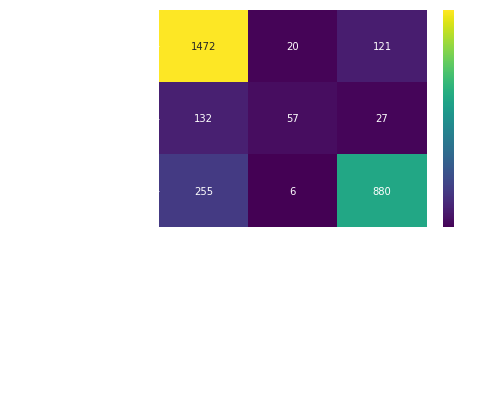

In [57]:
plot_confusion_matrix(y_val, y_pred);

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                       precision    recall  f1-score   support

           functional       0.79      0.91      0.85      1613
functionalneedsrepair       0.69      0.26      0.38       216
        nonfunctional       0.86      0.77      0.81      1141

             accuracy                           0.81      2970
            macro avg       0.78      0.65      0.68      2970
         weighted avg       0.81      0.81      0.80      2970



In [0]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]


In [0]:
y_val=np.where(y_val=='functional','functional','non-functional')

In [68]:
roc_auc_score(y_val, y_pred_proba)

0.473882981906863